In [51]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
df = pd.read_csv('../data/model_input.csv')
df = df[df['total_charges'] > 0].copy()
df['log_total_charges'] = np.log1p(df['total_charges'])

### Define LOS Segments

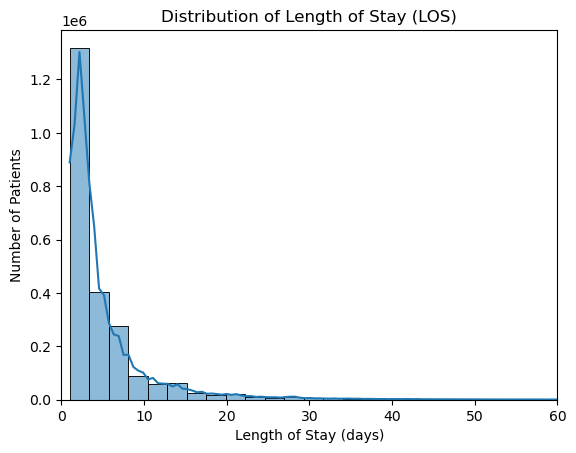

In [3]:
sns.histplot(df['los'], bins=50, kde=True)
plt.title("Distribution of Length of Stay (LOS)")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Number of Patients")
plt.xlim(0, 60)  # Optional: cap to ignore long-tail
plt.show()

## Interpretation: Length of Stay (LOS) Distribution
- The vast majority of patients stay between 1 and 7 days.

- There’s a sharp drop-off after day 7, and a long tail extending beyond 20–30 days.

- Very few patients stay beyond 30 days — this confirms extreme skew.

In [4]:
# Bin Length of Stay into interpretable categories
df['los_group'] = pd.cut(
    df['los'],
    bins=[0, 3, 7, 14, df['los'].max()],
    labels=['short', 'moderate', 'long', 'extended'],
    right=True
)

In [ ]:
df['los_group'].value_counts(normalize=True)


los_group
short       0.563316
moderate    0.261496
long        0.111452
extended    0.063736
Name: proportion, dtype: float64

 Define feature columns

In [ ]:
feature_cols = [
    'gender_encoded',
    'age_group_encoded',
    'severity_encoded',
    'admission_encoded',
    'payment_type_encoded',
    'diagnosis_encoded',
    'procedure_encoded',
    'county_encoded',
    'los'  
]

In [9]:
X = df[feature_cols]
y = np.log1p(df['total_charges'])

 Filter data for each group

In [7]:
short_df = df[df['los_group'] == 'short']
moderate_df = df[df['los_group'] == 'moderate']
long_df = df[df['los_group'] == 'long']
extended_df = df[df['los_group'] == 'extended']

Split train/test + train model for each group

In [13]:
# Select features and target for short LOS group
X_short = short_df[feature_cols]  # Only include relevant model input features
y_short = np.log1p(short_df['total_charges'])  # Apply log-transform to stabilize variance

# Split into training and test sets 
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
X_short, y_short, test_size=0.2, random_state=42)

## **Short** LOS Patients


In [14]:
model_s = lgb.LGBMRegressor(random_state=42)
model_s.fit(X_train_s, y_train_s)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 1055228, number of used features: 9
[LightGBM] [Info] Start training from score 9.650624


LGBMRegressor(random_state=42)

Predict on the test set (still in log scale)

In [15]:
y_pred_log_s = model_s.predict(X_test_s)

Inverse transform predictions and actuals to dollar scale

In [16]:
y_pred_s = np.expm1(y_pred_log_s)
y_actual_s = np.expm1(y_test_s)

Evaluate performance using Mean Absolute Error (MAE)


In [17]:
mae_s = mean_absolute_error(y_actual_s, y_pred_s)
print("Short LOS MAE:", mae_s)

Short LOS MAE: 7273.611788952628


## **Moderate** LOS Patients

In [ ]:
# Select features and target for moderate LOS group
X_moderate = moderate_df[feature_cols]  # Only include relevant model input features
y_moderate = np.log1p(moderate_df['total_charges'])  # Apply log-transform to stabilize variance

# Split into training and test sets 
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
X_moderate, y_moderate, test_size=0.2, random_state=42)

In [19]:
model_m = lgb.LGBMRegressor(random_state=42)
model_m.fit(X_train_m, y_train_m)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 489844, number of used features: 9
[LightGBM] [Info] Start training from score 10.425097


LGBMRegressor(random_state=42)

In [20]:
y_pred_log_m = model_m.predict(X_test_m)

In [26]:
y_pred_m = np.expm1(y_pred_log_m)
y_actual_m = np.expm1(y_test_m)

In [27]:
mae_m = mean_absolute_error(y_actual_m, y_pred_m)
print("Moderate LOS MAE:", mae_m)

Moderate LOS MAE: 13135.131579714482


## **Long** LOS Patients

In [22]:
# Select features and target for long LOS group
X_long = long_df[feature_cols]  # Only include relevant model input features
y_long= np.log1p(long_df['total_charges'])  # Apply log-transform to stabilize variance

# Split into training and test sets 
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
X_long, y_long, test_size=0.2, random_state=42)

In [23]:
model_l = lgb.LGBMRegressor(random_state=42)
model_l.fit(X_train_l, y_train_l)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 208776, number of used features: 9
[LightGBM] [Info] Start training from score 11.036781


LGBMRegressor(random_state=42)

In [24]:
y_pred_log_l = model_l.predict(X_test_l)

In [28]:
y_pred_l = np.expm1(y_pred_log_l)
y_actual_l = np.expm1(y_test_l)

In [31]:
mae_l = mean_absolute_error(y_actual_l, y_pred_l)
print("Long LOS MAE:", mae_l)

Long LOS MAE: 23670.70247887343


## **Extended** LOS Patients

In [46]:
# Select features and target for long LOS group
X_extended = extended_df[feature_cols]  # Only include relevant model input features
y_extended= np.log1p(extended_df['total_charges'])  # Apply log-transform to stabilize variance

# Split into training and test sets 
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
X_extended, y_extended, test_size=0.2, random_state=42)

In [47]:
model_e = lgb.LGBMRegressor(random_state=42)
model_e.fit(X_train_e, y_train_e)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 119393, number of used features: 9
[LightGBM] [Info] Start training from score 11.777569


LGBMRegressor(random_state=42)

In [48]:
y_pred_log_e = model_e.predict(X_test_e)

In [49]:
y_pred_e = np.expm1(y_pred_log_e)
y_actual_e = np.expm1(y_test_e)

In [50]:
mae_e = mean_absolute_error(y_actual_e, y_pred_e)
print("Exteneded LOS MAE:", mae_e)

Exteneded LOS MAE: 60723.68742795414


## Model Performance by Length of Stay (LOS)

| LOS Group     | MAE ($)         | Interpretation                                     |
|---------------|------------------|----------------------------------------------------|
| **Short**     | 7,274            | Predictable cases — model performs well.           |
| **Moderate**  | 13,135           | Growing variation — more complexity.               |
| **Long**      | 23,671           | High error — driven by complex, rare, or costly cases. |
| **Extended**  | 60,724    | Extremely costly and rare cases. Model struggles with extreme outliers.


## SHAP Analysis for Long and Extended LOS Groups

In [53]:
long_cases = long_df[feature_cols]
extended_cases = extended_df[feature_cols]

# Long LOS 
explainer_long = shap.Explainer(model_l)
shap_values_long = explainer_long(long_cases)

# Extended LOS
explainer_ext = shap.Explainer(model_e)
shap_values_ext = explainer_ext(extended_cases)

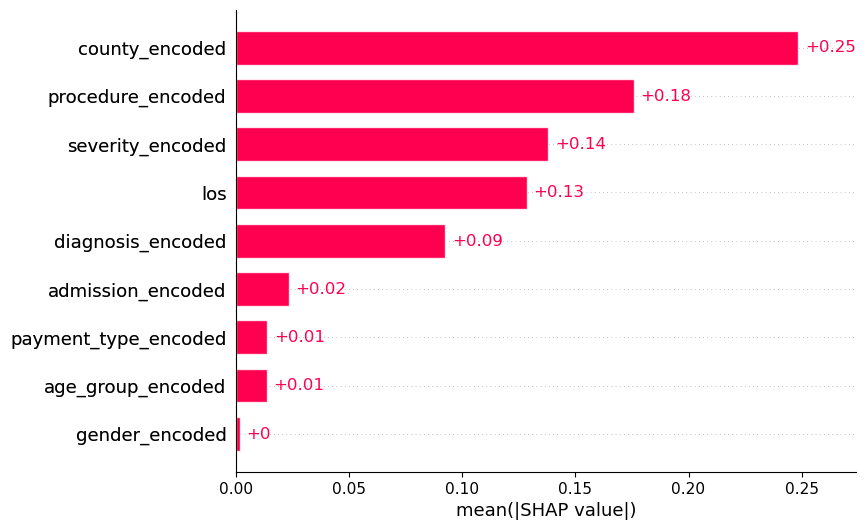

In [56]:
shap.plots.bar(shap_values_long, max_display=10)

### The most important features influencing predictions for **long-stay** patients were:
- **county_encoded:** Regional cost variation was the top driver of hospital charges.
- **procedure_encoded**: The type of procedure significantly impacted cost, reflecting clinical complexity.
- **severity_encoded:** Clinical severity increased cost unpredictability.

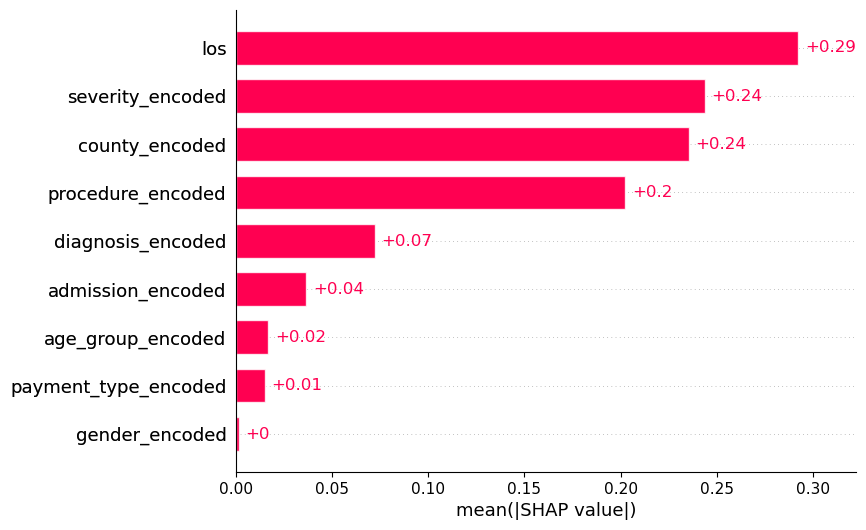

In [55]:
shap.plots.bar(shap_values_ext, max_display=10)

### The most important features for patients with **extremely long** hospitalizations were:
- **los:** The length of stay was the strongest predictor, directly driving total charges.
- **severity_encoded:** Very high-severity cases were tightly linked to prolonged costs.
- **county_encoded:** Geographic location continued to shape cost variation.


## Feature Engineering: Add Interaction Terms


In [71]:
df['los_x_severity'] = df['los'] * df['severity_encoded']
df['los_x_procedure'] = df['los'] * df['procedure_encoded']
df['severity_x_procedure'] = df['severity_encoded'] * df['procedure_encoded']
df['los_x_county'] = df['los'] * df['county_encoded']

# Add feautures to a list 
interaction_features = ['los_x_severity', 'los_x_procedure', 'severity_x_procedure', 'los_x_county']
feature_cols = feature_cols + interaction_features

#Remove any duplicates to prevent LightGBM errors
feature_cols = list(dict.fromkeys(feature_cols))

In [72]:
# Split by los group 
short_df = df[df['los_group'] == 'short'].copy()
moderate_df = df[df['los_group'] == 'moderate'].copy()
long_df = df[df['los_group'] == 'long'].copy()
extended_df = df[df['los_group'] == 'extended'].copy()

In [73]:
# Retrain with updated features
X_long = long_df[feature_cols]
y_long = np.log1p(long_df['total_charges'])

# Same for extended 
X_extended = extended_df[feature_cols]
y_extended = np.log1p(extended_df['total_charges'])

In [74]:
# Split into training and test sets 
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
X_long, y_long, test_size=0.2, random_state=42)

In [75]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
X_extended, y_extended, test_size=0.2, random_state=42)

## Long

In [76]:
model_l = lgb.LGBMRegressor(random_state=42)
model_l.fit(X_train_l, y_train_l)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1197
[LightGBM] [Info] Number of data points in the train set: 208776, number of used features: 13
[LightGBM] [Info] Start training from score 11.036781


LGBMRegressor(random_state=42)

In [77]:
y_pred_log_l = model_l.predict(X_test_l)

In [78]:
y_pred_l = np.expm1(y_pred_log_l)
y_actual_l = np.expm1(y_test_l)

In [79]:
mae_l = mean_absolute_error(y_actual_l, y_pred_l)
print("Long LOS MAE:", mae_l)

Long LOS MAE: 23803.5812119589


1st: 23670.70247887343 2nd: 23803.5812119589

In [80]:
model_e = lgb.LGBMRegressor(random_state=42)
model_e.fit(X_train_e, y_train_e)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 119393, number of used features: 13
[LightGBM] [Info] Start training from score 11.777569


LGBMRegressor(random_state=42)

In [81]:
y_pred_log_e = model_e.predict(X_test_e)

In [82]:
y_pred_e = np.expm1(y_pred_log_e)
y_actual_e = np.expm1(y_test_e)

In [83]:
mae_e = mean_absolute_error(y_actual_e, y_pred_e)
print("Exteneded LOS MAE:", mae_e)

Exteneded LOS MAE: 60464.24554828134


1st: 60723.68742795414
2nd: 60464.24554828134